# HIPÓTESIS 1


La tarjeta de datos de esta hipótesis enlazaba las ventas de modelos entre 2017 y 2022 de vehículos eléctricos con las especificaciones de estos mismos vehículos. Antes de poder obtenerla, vamos a importar todos los paquetes necesarios:


In [7]:
import pandas as pd
import os 
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import optuna
ruta_actual = os.getcwd()
print(ruta_actual)
directorio_superior = os.path.dirname(ruta_actual)
sys.path.append(directorio_superior)
from Acceso_BBDD.MetodosBBDD import *

c:\Users\mohae\Desktop\1ºSemestre\Mineria_de_datos\Laboratorio\Repositorio\MineriaDeDatosYSistemasMultiagentes\Conclusiones_Hipotesis


Ahora, ya podemos generar correctamente nuestra tarjeta de datos:

In [8]:
os.chdir(directorio_superior)
df = obtener_dataframe_sql('Hipotesis_1', GOLD)
os.chdir(ruta_actual)
columnas_ventas = df.iloc[:, 1:7]  # Columnas de años

# Multiplica las columnas de años para obtener un total de ventas por año
df['RapidCharge'] = df['RapidCharge'].replace({'Yes': 1, 'No': 0}) #Adaptamos el boolean a numerico
total_ventas_por_año = columnas_ventas.sum(axis=1)

df_mod=df.select_dtypes(include='number')
df_mod['Ventas_Totales']=total_ventas_por_año
df_mod['Model']=df['Model']
df_mod['Segment']=df['Segment']
df_mod.set_index(df_mod['Model'], inplace=True)

for i in range(2017,2023):
    df_mod = df_mod.drop(columns=str(i))

df_mod = df_mod.drop(columns='Model')
df_mod['RapidCharge']=df_mod['RapidCharge'].astype(float)

#Finalmente en df_mod tendremos la tarjeta de datos indexada por modelos

segment=df_mod.groupby('Segment') #En segment guardaremos la tarjeta de datos indexada por segmentos para despues

df_mod=df_mod.drop(columns='Segment') #Prescindimos de los segmentos en la tarjeta original por no ser numericos ni tener relacion posible

In [9]:
df_mod

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro,RapidCharge,Ventas_Totales
Model,,,,,,,,
180SX,8.57,155.86,290.00,187.90,5.00,43847.14,1.0,1.0
Ampera-e,7.30,150.00,335.00,173.00,5.00,41906.00,1.0,9446.0
EQA,5.00,200.00,350.00,171.00,5.00,45000.00,1.0,51770.0
Fox/Cross Fox,6.10,200.00,317.50,198.50,4.50,93711.00,1.0,158725.0
Go+,9.60,150.00,190.00,168.00,5.00,31900.00,1.0,32372.0
ID.3,8.30,160.00,348.00,170.00,4.80,35699.60,1.0,210393.0
ID.4 CROZZ,7.50,160.00,420.00,183.00,5.00,45000.00,1.0,72381.0
Kadett,22.40,130.00,160.00,194.00,5.00,38000.00,0.0,0.0
Kona,8.90,161.00,327.50,157.00,5.00,37383.00,1.0,1287601.0



La idea con estos datos es probar nuestra hipótesis que dice que se venden más coches eléctricos con respecto mejoren sus características. La única transformación que nos ha hecho falta sería transformar todos los datos que no eran numéricos en numéricos o deshacernos de ellos porque no eran “relevantes”; para ello, la variable booleana “RapidCharge”, la hemos pasado a 0 y 1 para false y true respectivamente. De momento, nos hemos deshecho de las variables “Segment” y “BodyType” porque a priori expresarían lo mismo y no ayudarían de momento. Para ello, probaremos la correlación que exista entre las variables de las especificaciones de cada coche por separado con las ventas del mismo: 

In [10]:
def verCorrelaciones(df,segmentL):
    #Para este ejemplo obviaremos los segmentos
    correlation_matrix = df.corr() 
    sns.set(style="white")
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    if segmentL=='':
        plt.title("Matriz de Correlación entre todas las variables")
    else:
        plt.title(f"Matriz de Correlación entre todas las variables del segmento {segmentL}")
    plt.xlabel("Variables")
    plt.ylabel("Variables")
    plt.show()

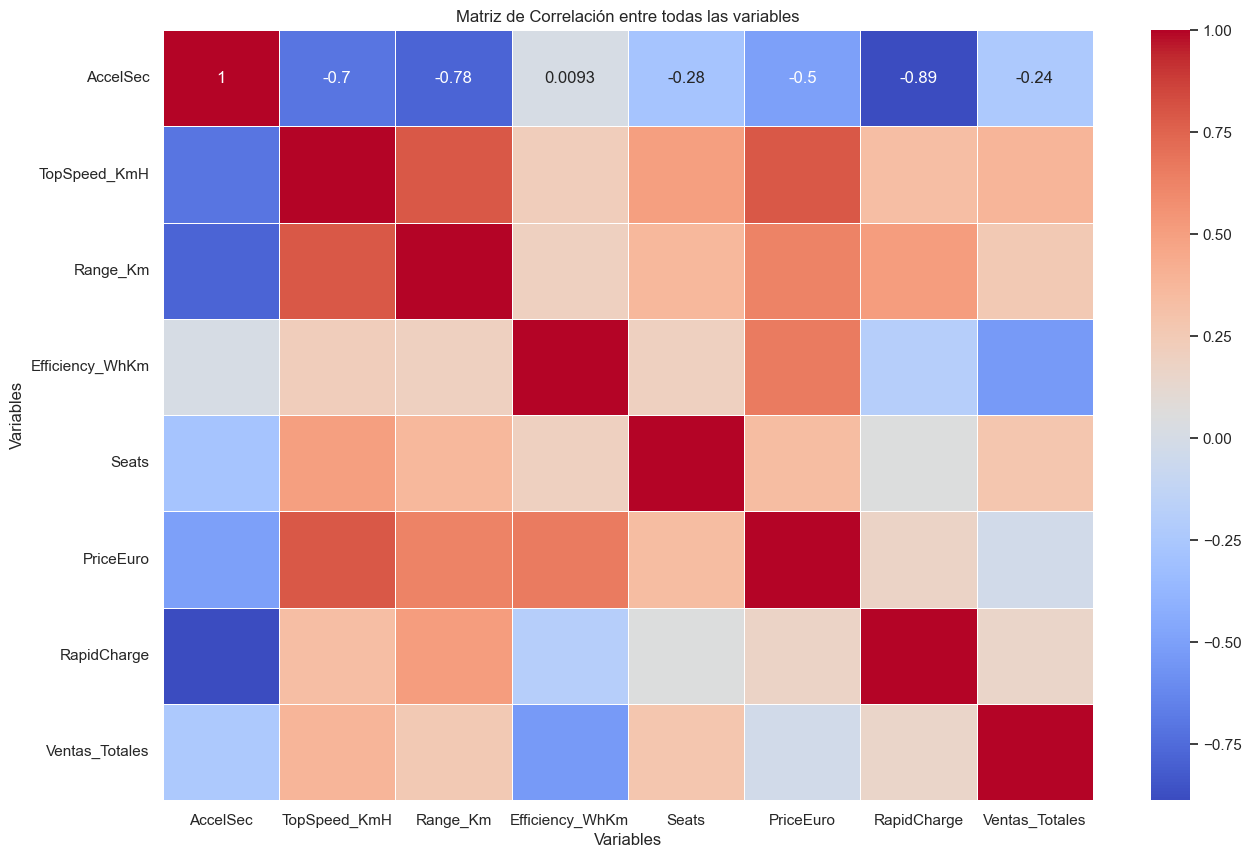

In [11]:
verCorrelaciones(df_mod,'')

Como podemos ver, esto no nos lleva a ninguna conclusión lógica pues no existe ningún grado de correlación relevante entre venta y ninguna especificación. Una relación que cabe a destacar es la relación entre ventas totales y AccelSec, que pareciera inversamente proporcional, pero esto es debido a que la aceleración es mayor a menor sea este dato, pues se expresa en los segundos que tarda en pasar de 0 a 100 kph. Lo más destacable dentro de esta tabla sería la correlación que hay entre las ventas totales y la velocidad máxima, ¿se compran más coches con respecto a más alta sea su velocidad máxima? En principio, podríamos decir que sí y esto se apoyaría en que también se compran más coches con respecto a mayor aceleración tengan, pero también vemos que se compran más coches con respecto a más asientos tengan, con lo que podríamos estar viendo aquí un conflicto de “públicos”. 

Dentro de esta tarjeta se hablan al mismo nivel de coches con un carácter deportivo que de coches con un carácter familiar o incluso empresarial; es por ello que vemos variables tan poco correlacionadas, pues poco o nada tienen que ver las intenciones de la persona que compra un deportivo que de la persona que compra un coche familiar. Es por esto que decidimos dividir esta tarjeta de datos en cinco tarjetas de datos, una por segmento de coches, que, si bien no dividen los coches por deportivos, familiares... Los divide por tamaño de la carrocería, lo que hace que los deportivos estén encasillados únicamente en el segmento D y E (Berlinas de grandes dimensiones como serían en este caso los Teslas con carácter más deportivo). 

Para esto, aprovecharemos los dataframe segment que hemos creado ateriormente:

C:\Users\mohae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


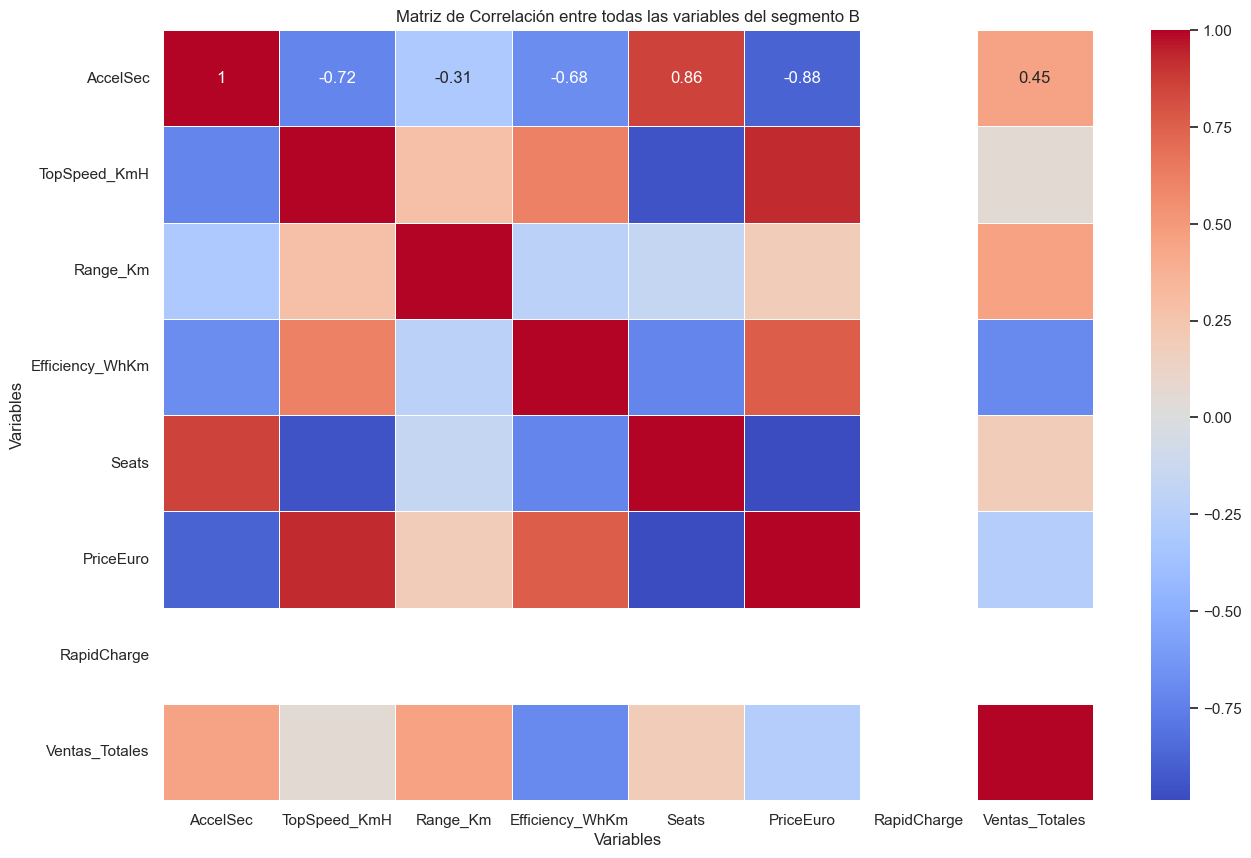

C:\Users\mohae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


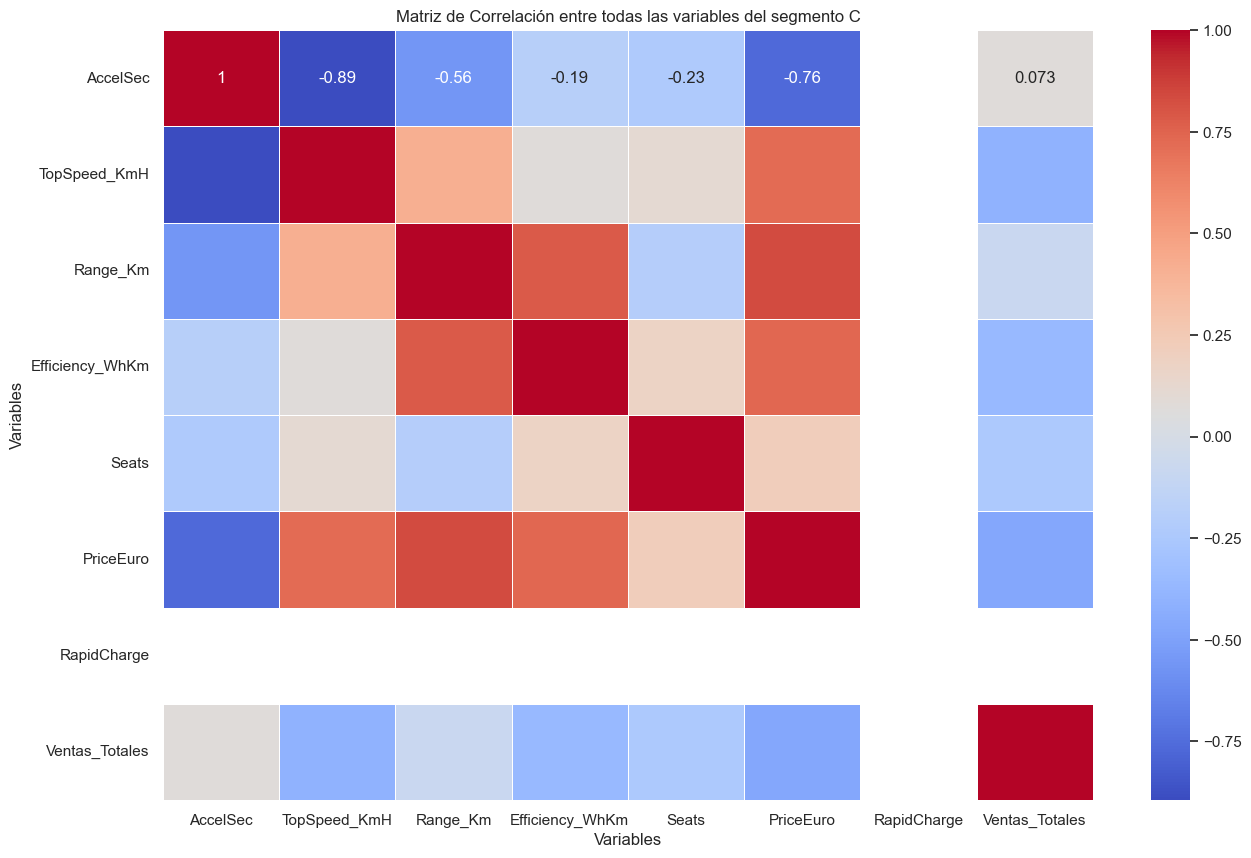

C:\Users\mohae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


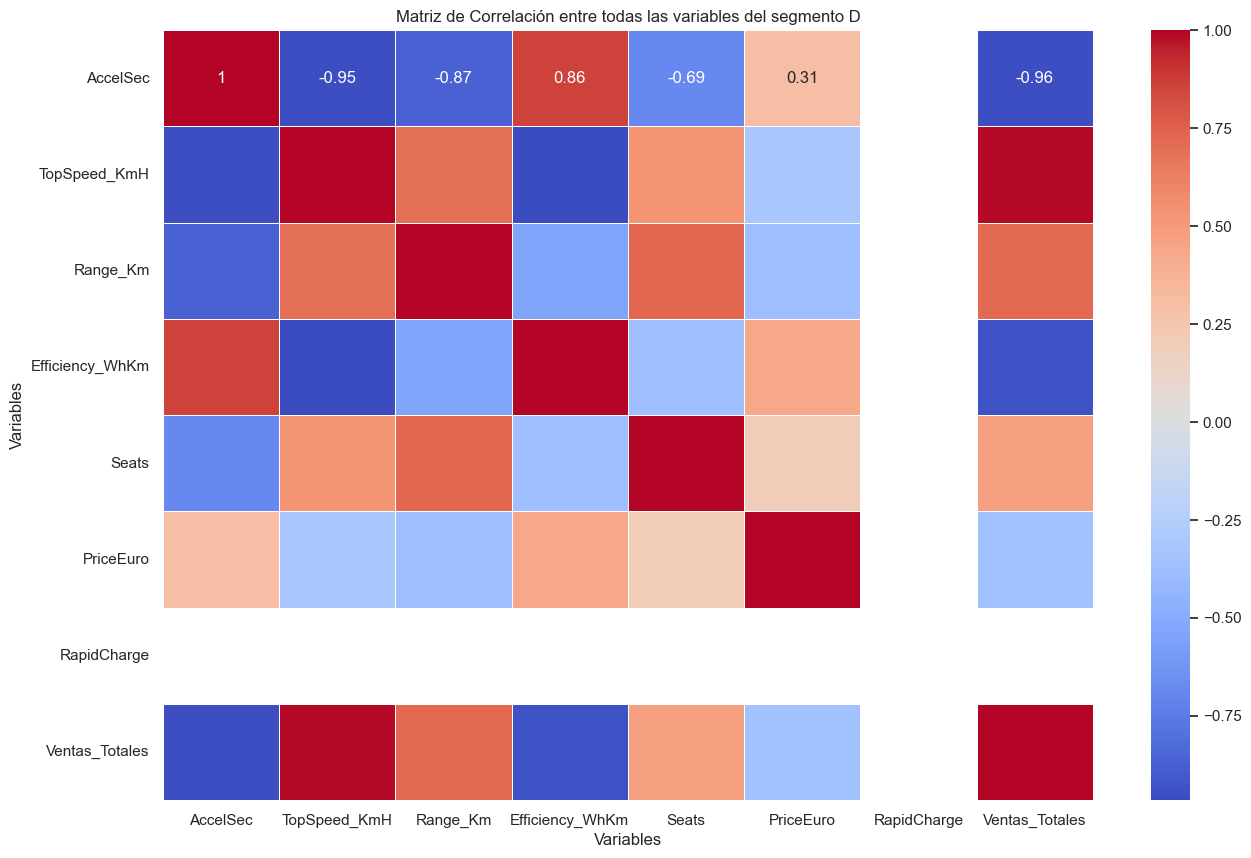

C:\Users\mohae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


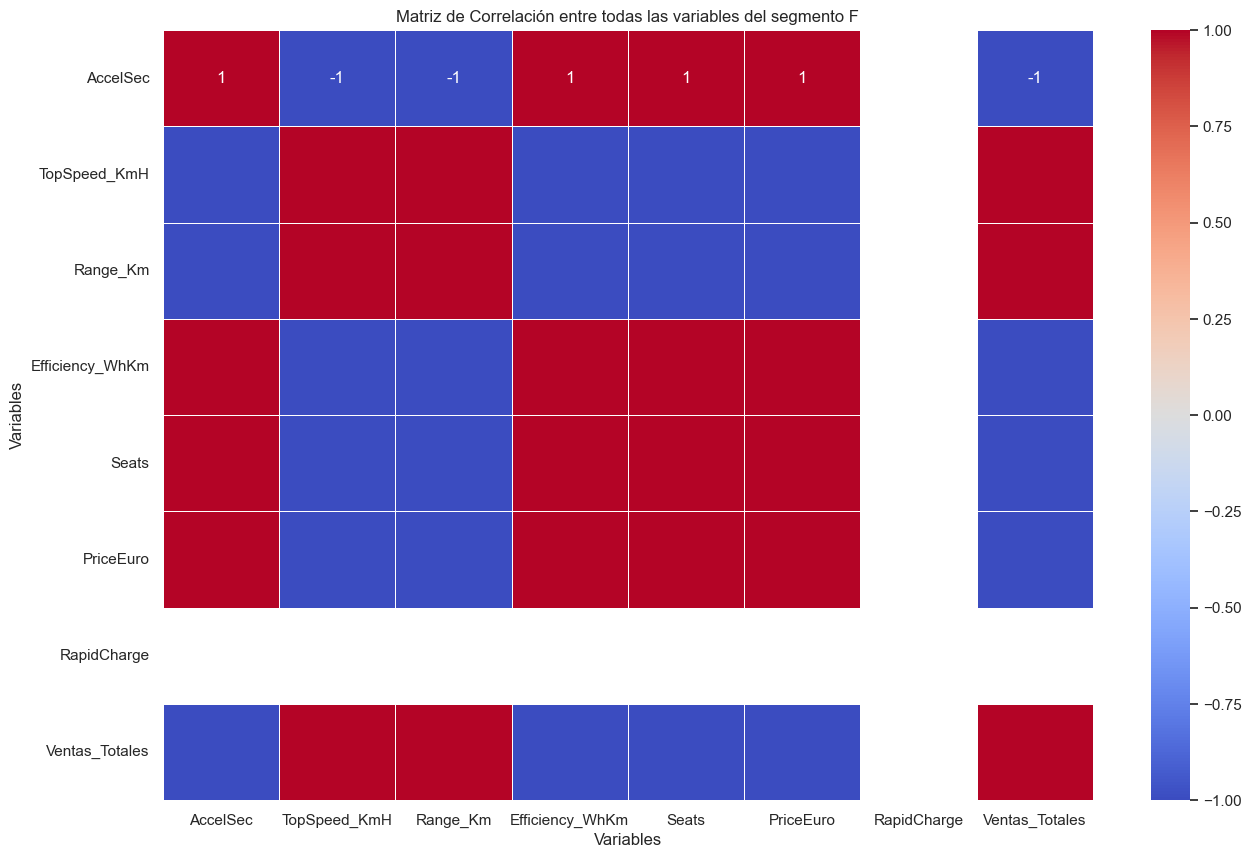

In [12]:
data_segment = {nombre: grupo for nombre, grupo in segment}
    
for valor, dataset in data_segment.items():
    if valor!= 'N':
        verCorrelaciones(dataset.drop(columns='Segment'),valor)

Ahora procederemos a explicar las tablas una por una:
# Correlaciones en el segmento B:

Ahora sí podemos ver algunos grados de relación más interesantes. En el segmento B se engloban los coches compactos, de carrocería más pequeña y por tanto más orientados a la conducción cómoda por ciudad. Podemos ver que lo que menos relevancia tiene para el comprador es sin duda la velocidad máxima con un grado de correlación de 0.054, algo que tiene sentido si tenemos en cuenta el carácter urbano que tienen estos coches. Sin embargo, algo que también va con el carácter urbano de estos coches es la aceleración, a sus compradores les interesa poder salir cuanto antes en un semáforo o poder incorporarse rápidamente en cualquier vía más grande, y esto lo vemos también reflejado en el cuadro de correlaciones, con un grado de correlación del 0.45. El precio también parece ser relevante, pues a menos precios más ventas (Con una relación del -0.26), cosa que parece lógica también de este segmento. La relación con mayor grado es la de la eficiencia de carga, que parece no interesar mucho a los compradores de este segmento, pues a menor eficiencia más ventas. Esto realmente también puede tener una explicación técnica, y es que, a mayor eficiencia de carga, menos durará la batería (en ciclos de vida) y de hecho también podemos ver que más rango tendrá en este mismo cuadro de coeficientes; con lo cual va de la mano con que los conductores de este segmento prefieran tener mayor rango de km. 

# Correlaciones en el segmento C:

El segmento C es un segmento de coches medianos y sobre todo orientados a un público mixto que quiere tanto hacer viajes como poder conducir en ciudad, y esto se ve reflejado en que lo que menos le interesa a este sector es la velocidad máxima (-0.41 de relación) y que tenga un precio menor (-0.47 de relación). Sin embargo, en este caso también vemos que este público no compra más un coche porque tenga más autonomía, lo cual chocaría con sus principales gustos y además con que también compran menos coches a más eficiencia de carga tengan. Esto es principalmente debido a que en los coches que hemos estudiado en este segmento se incluyen coches hechos por compañías como Volkswagen o Nissan que ya tenían muchas ventas antes de hacer eléctricos, con lo que el comprador muy probablemente se guíe más por el historial de estas marcas y su fama que por los requisitos técnicos de los mismos. 

# Correlaciones en el segmento D:

Llegamos al Segmento D, el segmento de las berlinas medias y deportivas. En este caso, si bien es cierto que se incluyen vehículo scon un carcater más deportivo, hay que decir que son berlinas deportivas, que no buscan el rendimiento en circuito únicamente si no que sobre todo buscan el lujo y la comodidad de hacer largos viajes en carretera más rápidamente. Estos intereses son los que hacen que haya una relación casi perfecta del 0.99 entre las ventas y la velocidad máxima, pues los compradores de este vehículo suponen un uso del mismo casi exclusivo por autovías (Como la autobhan alemana donde no hay límite de velocidad) y quieren poder viajar a altas velocidades cómodamente. Evidentemente también hay un muy alto interés en la autonomía, teniendo una relación del 0.72, y un interés por más asientos, con un 0.47. Donde más desinterés muestran estos conductores es en el precio, pues al comprarse un vehículo de lujo, no se fijan demasiado.  

Es cierto que no hemos mencionado nada sobre AccelSec donde hay una relación del –0.96 que no cuadra con este segmento tan deportivo, pero este dato está algo “manchado”, ya que dentro de este segmento se encuentra el Tesla model 3, modelo que lleva muchos años siendo el eléctrico más vendido. Esto hace que parezca que todos los compradores quieran el coche con menor aceleración de 0 a 100, no obstante, si quitásemos este vehículo de la lista, la relación quedaría en torno al 0.27, que tampoco es mucho por lo que hemos dicho, se busca la comodidad y el lujo en carretera que el rendimiento en circuito. 

# Correlaciones en el segmento F:

Entramos en el segmento F, segmento de berlinas mayores de 5 metros donde solo tenemos dos modelos disponibles, el Tesla model Y y el Tesla model X, con lo que las correlaciones son algo engañosas. No obstante, podemos ver casi lo mismo que en el segmento anterior al ser del mismo carácter, se busca principalmente velocidad y autonomía antes que precio o eficiencia a la hora de cargar el vehículo.  

 

Podríamos añadir el segmento N, pero solo tenemos un vehículo dedicado exclusivamente a uso industrial, y sería precipitado sacar conclusiones con sus datos únicamente 

# Conclusiones 

En conclusión ¿Se venden más vehículos eléctricos con respecto mejores sean sus características? A grandes rasgos, podríamos decir que sí, pero para ello primero habría que afinar la hipótesis ¿A qué nos referimos con mejores características? Porque si hablamos de si los compradores buscan cualquier coche que sea lo mejor en todas sus características, la respuesta sería un rotundo no. No obstante, si hacemos una particularización por sector y nos referimos a que los compradores buscan las mejores características que necesiten, entonces podremos decir sin temor a equivocarnos que sí. 

En este análisis de datos hemos podido comprobar que, en su mayoría, los compradores eligen su coche en función de las características que más les interesan. Es cierto que hemos visto también que hay casos en los que la fama y la marca predomina sobre cualquier característica, pero en cualquier caso hablamos de casos concretos y no podríamos decir que esto rompa la con la media de compradores que solo se fijan en las características. 
